In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow.keras import datasets, layers, models


In [33]:
base_dir = "data/"

In [34]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [35]:
classes = os.listdir(base_dir)
classes.pop(1)
print(classes)

['Car', 'Bike']


In [36]:
exts = ['jpg', 'png', 'jpeg', 'bnp']
for image_class in classes:
    for image in os.listdir(os.path.join(base_dir, image_class)):
        image_path = os.path.join(base_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with {}".format(image_path))

In [37]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 3981 files belonging to 2 classes.


In [38]:
data = data.map(lambda x,y: (x/255,y))
scaled_iterator = data.as_numpy_iterator()
scaled_batch = data_iterator.next()

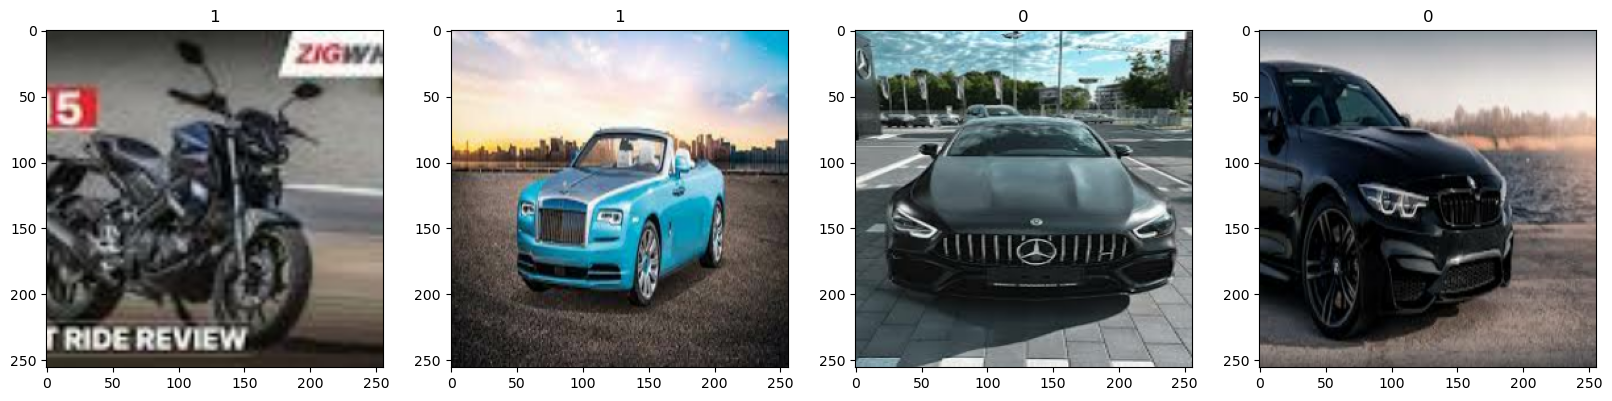

In [39]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [40]:
train_size = int(len(data) * .7)
test_size = int(len(data) * .2) + 1
val_size = int(len(data) * .1) + 1

In [41]:
train = data.take(train_size)
test = data.skip(train_size).take(test_size)
val = data.skip(train_size+test_size).take(val_size)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [43]:
model = Sequential()

In [44]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

# model.add(Conv2D(32, (3,3),1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(64, (3,3),1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [45]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 516128)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                33032256  
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33,033,217
Trainable params: 33,033,217
Non-trainable params: 0
__________________________________________

In [47]:
logdir = 'logs'

In [48]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [49]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
87/87 [==============================] - 60s 671ms/step - loss: 1.9729 - accuracy: 0.7432 - val_loss: 0.3729 - val_accuracy: 0.8466
Epoch 2/3
87/87 [==============================] - 58s 667ms/step - loss: 0.1754 - accuracy: 0.9332 - val_loss: 0.2903 - val_accuracy: 0.8685
Epoch 3/3
87/87 [==============================] - 57s 651ms/step - loss: 0.0660 - accuracy: 0.9824 - val_loss: 0.2864 - val_accuracy: 0.8795


In [50]:
hist.history

{'loss': [1.9729063510894775, 0.17536914348602295, 0.06604857742786407],
 'accuracy': [0.7431752681732178, 0.9331896305084229, 0.9823994040489197],
 'val_loss': [0.37287309765815735, 0.29030492901802063, 0.28641223907470703],
 'val_accuracy': [0.8465753197669983, 0.8684931397438049, 0.8794520497322083]}

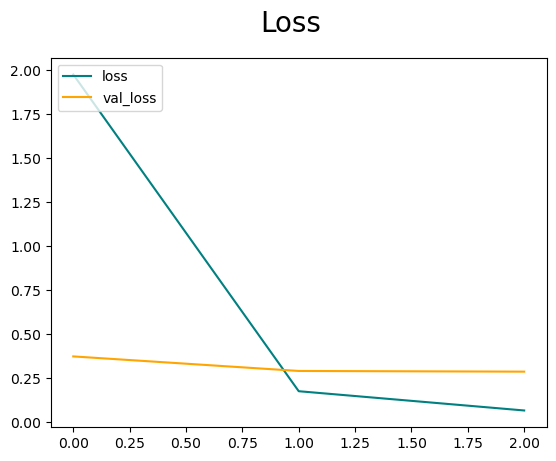

In [51]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label = 'loss')
plt.plot(hist.history['val_loss'], color='orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [52]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [53]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [54]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 135ms/step


In [55]:
print(
    f'Precisions:{pre.result().numpy()}, Recall:{re.result().numpy()}, Recall:{re.result().numpy()}')


Precisions:0.9066985845565796, Recall:0.9066985845565796, Recall:0.9066985845565796


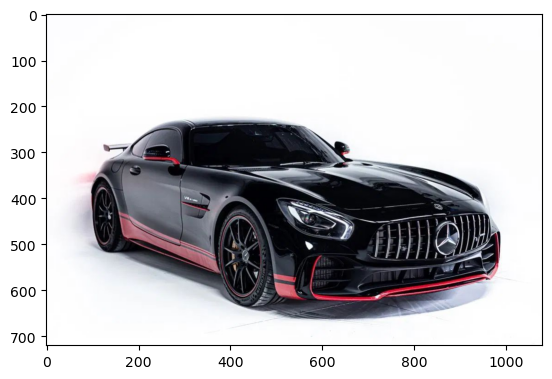

In [56]:
# 2023-Yamaha-MT10DX-EU-Icon_Performance-Studio-001-03_Mobile.jpeg
# Mercedes-Benz-AMG-GT-R-DRIFT-765KM-by-JOSE-Kolekcjoner-6.jpeg
img = cv2.imread('Mercedes-Benz-AMG-GT-R-DRIFT-765KM-by-JOSE-Kolekcjoner-6.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

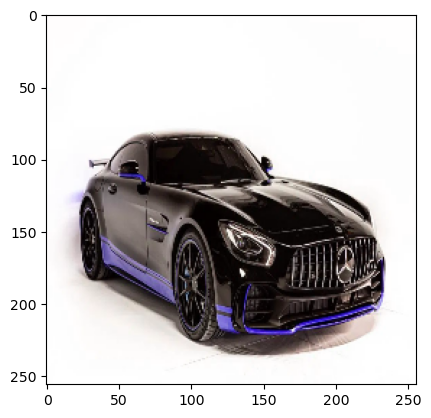

In [57]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))

In [58]:
pred = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 64ms/step


In [59]:
pred[0][0]

0.9920394